# Izhikevich model

In [1]:
from collections import OrderedDict

import brainpy as bp
import matplotlib.pyplot as plt

bp.profile.set(dt=0.01)

In [2]:
a = 0.02
b = 0.20
c = -65.
d = 8.
Vth = 30.


def get_Izhikevich(mode=None):
    state = bp.types.NeuState({'V': 0., 'u': 1., 'sp': 0., 'input': 0.})

    global a, b, c, d

    if mode in ['tonic', 'tonic spiking']:
        a, b, c, d = [0.02, 0.40, -65.0, 2.0]
    elif mode in ['phasic', 'phasic spiking']:
        a, b, c, d = [0.02, 0.25, -65.0, 6.0]
    elif mode in ['tonic bursting']:
        a, b, c, d = [0.02, 0.20, -50.0, 2.0]
    elif mode in ['phasic bursting']:
        a, b, c, d = [0.02, 0.25, -55.0, 0.05]
    elif mode in ['mixed mode']:
        a, b, c, d = [0.02, 0.20, -55.0, 4.0]
    elif mode in ['SFA', 'spike frequency adaptation']:
        a, b, c, d = [0.01, 0.20, -65.0, 8.0]
    elif mode in ['Class 1', 'class 1']:
        a, b, c, d = [0.02, -0.1, -55.0, 6.0]
    elif mode in ['Class 2', 'class 2']:
        a, b, c, d = [0.20, 0.26, -65.0, 0.0]
    elif mode in ['spike latency', ]:
        a, b, c, d = [0.02, 0.20, -65.0, 6.0]
    elif mode in ['subthreshold oscillation', ]:
        a, b, c, d = [0.05, 0.26, -60.0, 0.0]
    elif mode in ['resonator', ]:
        a, b, c, d = [0.10, 0.26, -60.0, -1.0]
    elif mode in ['integrator', ]:
        a, b, c, d = [0.02, -0.1, -55.0, 6.0]
    elif mode in ['rebound spike', ]:
        a, b, c, d = [0.03, 0.25, -60.0, 4.0]
    elif mode in ['rebound burst', ]:
        a, b, c, d = [0.03, 0.25, -52.0, 0.0]
    elif mode in ['threshold variability', ]:
        a, b, c, d = [0.03, 0.25, -60.0, 4.0]
    elif mode in ['bistability', ]:
        a, b, c, d = [1.00, 1.50, -60.0, 0.0]
    elif mode in ['DAP', 'depolarizing afterpotential']:
        a, b, c, d = [1.00, 0.20, -60.0, -21.0]
    elif mode in ['accomodation', ]:
        a, b, c, d = [0.02, 1.00, -55.0, 4.0]
    elif mode in ['inhibition-induced spiking', ]:
        a, b, c, d = [-0.02, -1.00, -60.0, 8.0]
    elif mode in ['inhibition-induced bursting', ]:
        a, b, c, d = [-0.026, -1.00, -45.0, 0.0]

    @bp.integrate
    def int_u(u, t, V):
        return a * (b * V - u)

    @bp.integrate
    def int_V(V, t, u, Isyn):
        return 0.04 * V * V + 5 * V + 140 - u + Isyn

    def update(ST, _t):
        V = int_V(ST['V'], _t, ST['u'], ST['input'])
        u = int_u(ST['u'], _t, ST['V'])
        if V >= Vth:
            V = c
            u += d
            ST['sp'] = True
        ST['V'] = V
        ST['u'] = u
        ST['input'] = 0.

    return bp.NeuType(name='Izhikevich',
                      ST=state,
                      steps=update,
                      mode='scalar')

## Simulation

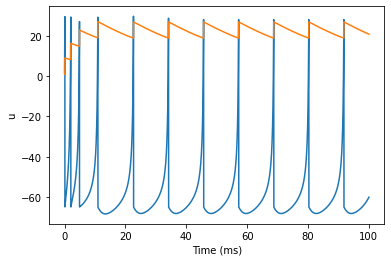

In [3]:
neuron = get_Izhikevich()

group = bp.NeuGroup(neuron, 1, monitors=['V', 'u'])
group.run(100., inputs=('ST.input', 40.))
bp.visualize.line_plot(group.mon.ts, group.mon.V, ylabel='Potential (mV)')
bp.visualize.line_plot(group.mon.ts, group.mon.u, ylabel='u', show=True)

## Phase plane analysis

SymPy solve "int_u(V, u) = 0" to "u = f(V, )", success.
SymPy solve "int_V(V, u) = 0" to "u = f(V, )", success.
SymPy solve derivative of "int_V(V, u)" by "V", success.
SymPy solve derivative of "int_V(V, u)" by "u", success.
SymPy solve derivative of "int_u(V, u)" by "V", success.
SymPy solve derivative of "int_u(V, u)" by "u", success.


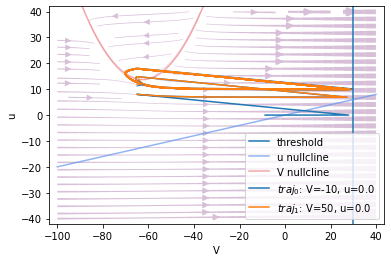

In [4]:
analyzer = bp.analysis.PhasePlane(
    model=neuron,
    target_vars=OrderedDict(V=[-100, 40], u=[-40., 40.]),
    fixed_vars={'Isyn': 30.})
plt.axvline(Vth, label='threshold')
analyzer.plot_nullcline()
analyzer.plot_vector_field()
analyzer.plot_fixed_point()
analyzer.plot_trajectory([{'V': -10, 'u': 0.}, {'V': 50, 'u':0.}],
                         duration = 100.,
                         inputs=('ST.input', 30.),
                         show=True)